<a href="https://colab.research.google.com/github/zanderVenter/GEE_misc/blob/master/multiclass_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install rioxarray if you are running this in Colab:

In [28]:
%pip install rioxarray -q

^C
ERROR: Operation cancelled by user
Note: you may need to restart the kernel to use updated packages.


Import relevant libraries for this starter script:

In [338]:
import os
import rioxarray as rxr
import rasterio as rio
import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
from matplotlib.patches import Patch
import numpy as np
from pathlib import Path

Fetch the satellite imagery and their masks fromt he GitHub repo:

In [34]:
!git clone https://github.com/NINAnor/test-multiclass-segmentation.git

fatal: destination path 'test-multiclass-segmentation' already exists and is not an empty directory.


# 

Reset root directory and list the image files

In [2]:
# root = Path('test-multiclass-segmentation/dset-s2-grunnkart')
root = Path('dset-s2-grunnkart')

assert root.exists()

train_imgs = list((root/'tra_scene').glob('*.tif'))
train_masks = list((root/'tra_truth').glob('*.tif'))

val_imgs = list((root/'val_scene').glob('*.tif'))
val_masks = list((root/'val_truth').glob('*.tif'))

# As the images and corresponding masks are matched by name, we will sort both lists to keep them synchronized.
train_imgs.sort(); train_masks.sort(); val_imgs.sort(); val_masks.sort()

Open one image and one mask and plot:

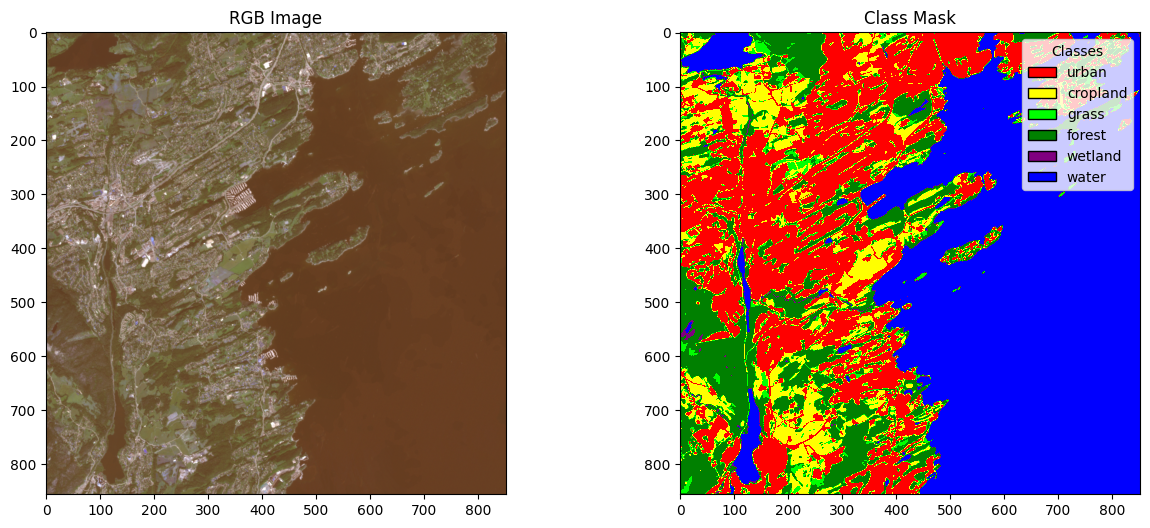

In [3]:
idx = 3
img = rxr.open_rasterio(train_imgs[idx])
mask = rxr.open_rasterio(train_masks[idx])

_, axs = plt.subplots(1, 2, figsize=(15, 6))

# Define the class labels and corresponding colors
class_labels = ['urban', 'cropland', 'grass', 'forest', 'wetland', 'water']
class_colors = ['red', 'yellow', 'lime', 'green', 'purple', 'blue']

# plot the tile
rgb = img.data[[2, 1, 0]].transpose((1, 2, 0))/2000
axs[0].imshow(rgb.clip(min=0, max=1))
axs[0].set_title("RGB Image")

# plot the mask
axs[1].imshow(mask.data.squeeze(), cmap=ListedColormap(class_colors))
axs[1].set_title("Class Mask")
legend_elements = [Patch(facecolor=color, edgecolor='black', label=label)
                   for color, label in zip(class_colors, class_labels)]

# Add the legend to the second subplot
axs[1].legend(handles=legend_elements, loc='upper right', title="Classes")

In [4]:
def read_images_and_masks(indices, train_imgs, train_masks):
    # Define the class labels and corresponding colors
    class_labels = ['urban', 'cropland', 'grass', 'forest', 'wetland', 'water']
    class_colors = ['red', 'yellow', 'lime', 'green', 'purple', 'blue']
    
    # Initialize dictionaries to store images and masks
    images = {}
    masks = {}

    # Loop through the specified indices
    for idx in indices:
        # Read the image and mask files
        images[idx] = rxr.open_rasterio(train_imgs[idx])
        masks[idx] = rxr.open_rasterio(train_masks[idx])
    
    return images, masks, class_labels, class_colors

In [5]:
indices = range(0, 4)  # Indices from 0 to 3

images, masks, class_labels, class_colors = read_images_and_masks(indices, train_imgs, train_masks)
valimages, valmasks, class_labels, class_colors = read_images_and_masks(indices, train_imgs, train_masks)

In [6]:
masks[3].shape

(1, 856, 852)

In [7]:
images[0].shape

(6, 851, 848)

In [8]:
valimages[2].shape

(6, 856, 853)

In [195]:
def jaccard_score1(y_true, y_pred, smooth=1e-6):
    """
    Calculates the Jaccard score, a.k.a IoU for each class and returns the mean.
    
    Args:
    y_true: The ground truth labels.
    y_pred: The predictions.
    smooth: A small constant to avoid division by zero.
    
    Returns:
    The Jaccard score (mean IoU) across all classes.
    """
    # Argmax to convert from one-hot encoded predictions to class integer labels
    y_pred = tf.argmax(y_pred, axis=-1)
    y_true = tf.argmax(y_true, axis=-1)

    # Convert to int32 for intersection and union calculation
    y_pred = tf.cast(y_pred, tf.int32)
    y_true = tf.cast(y_true, tf.int32)
    
    # Calculate Intersection and Union per class
    intersection = tf.math.logical_and(tf.equal(y_true, y_pred), tf.not_equal(y_true, 0)) # Ignoring background class
    union = tf.math.logical_or(tf.equal(y_true, y_pred), tf.not_equal(y_true, 0)) # Ignoring background class
    intersection = tf.reduce_sum(tf.cast(intersection, tf.float32))
    union = tf.reduce_sum(tf.cast(union, tf.float32))
    
    # Compute the IoU and mean over classes
    iou = (intersection + smooth) / (union + smooth)
    return iou

In [320]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Input, Cropping2D
from tensorflow.keras.models import Model

# def conv_block(input_tensor, num_filters):
#     x = Conv2D(num_filters, (3, 3), activation='relu', padding='same')(input_tensor)
#     x = Conv2D(num_filters, (3, 3), activation='relu', padding='same')(x)
#     return x

# def encoder_block(input_tensor, num_filters):
#     x = conv_block(input_tensor, num_filters)
#     p = MaxPooling2D((2, 2), padding='same')(x)  # Ensure dimensionality remains divisible
#     return x, p

# def decoder_block(input_tensor, concat_tensor, num_filters):
#     x = Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same')(input_tensor)
    
#     # Calculate the crop needed for the concatenation tensor
#     crop_height = (concat_tensor.shape[1] - x.shape[1]) // 2
#     crop_width = (concat_tensor.shape[2] - x.shape[2]) // 2
#     cropped_concat_tensor = Cropping2D(((crop_height, crop_height), (crop_width, crop_width)))(concat_tensor)
    
#     x = concatenate([x, cropped_concat_tensor], axis=-1)
#     x = conv_block(x, num_filters)
#     return x

# def unet_model(input_shape):
#     inputs = Input(input_shape)
    
#     # Encoder
#     c1, p1 = encoder_block(inputs, 64)
#     c2, p2 = encoder_block(p1, 128)
#     c3, p3 = encoder_block(p2, 256)
#     c4, p4 = encoder_block(p3, 512)
    
#     # Bridge
#     b = conv_block(p4, 1024)
    
#     # Decoder
#     d1 = decoder_block(b, c4, 512)
#     d2 = decoder_block(d1, c3, 256)
#     d3 = decoder_block(d2, c2, 128)
#     d4 = decoder_block(d3, c1, 64)
    
#     # Output
#     outputs = Conv2D(6, (1, 1), activation='softmax')(d4)  # Using sigmoid for binary classification
    

#     model = Model(inputs=[inputs], outputs=[outputs])
#     return model

# # Adjust the model input size according to your needs
# model = unet_model((848, 848, 6))  # Channels last in TensorFlow
# # model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# model.summary()

import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Input, Cropping2D
from tensorflow.keras.models import Model

def conv_block(input_tensor, num_filters):
    # Using only one Conv2D layer instead of two
    x = Conv2D(num_filters, (3, 3), activation='tanh', padding='same')(input_tensor)
    return x

def encoder_block(input_tensor, num_filters):
    x = conv_block(input_tensor, num_filters)
    p = MaxPooling2D((2, 2), padding='same')(x)
    return x, p

def decoder_block(input_tensor, concat_tensor, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same')(input_tensor)
    # Handle potential size mismatch for concatenation
    x = concatenate([x, concat_tensor], axis=-1)
    x = conv_block(x, num_filters)
    return x

def unet_model(input_shape, base_filters=32):  # Reduced number of base filters
    inputs = Input(input_shape)
    
    # Encoder with reduced depth and fewer filters
    c1, p1 = encoder_block(inputs, base_filters)
    c2, p2 = encoder_block(p1, base_filters * 2)
    
    # Bridge
    b = conv_block(p2, base_filters * 4)
    
    # Decoder
    d1 = decoder_block(b, c2, base_filters * 2)
    d2 = decoder_block(d1, c1, base_filters)
    
    # Output layer for multiclass segmentation, assuming 6 classes
    outputs = Conv2D(6, (1, 1), activation='softmax')(d2)
    
    model = Model(inputs=[inputs], outputs=[outputs])
    return model

# Create the model with reduced complexity
model = unet_model((848, 848, 6), base_filters=32)
# model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "model_37"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_40 (InputLayer)          [(None, 848, 848, 6  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_651 (Conv2D)            (None, 848, 848, 32  1760        ['input_40[0][0]']               
                                )                                                                 
                                                                                                  
 max_pooling2d_140 (MaxPooling2  (None, 424, 424, 32  0          ['conv2d_651[0][0]']             
 D)                             )                                                          

In [11]:
# unet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [12]:
import cv2


In [13]:


image_arr = images[0][:, 0:848,0:848] 
image_arr1 = images[1][:, 0:848,0:848] 
image_arr2 = images[2][:, 0:848,0:848] 
image_arr3 = images[3][:, 0:848,0:848] 
images_crop = []
images_crop.append(image_arr)

images_crop.append(image_arr1)
images_crop.append(image_arr2)
images_crop.append(image_arr3)

images_crop = np.moveaxis(images_crop, 1, -1)


In [14]:
images_crop.shape

(4, 848, 848, 6)

In [15]:
images_crop[1].shape

(848, 848, 6)

In [20]:
mask_arr = masks[0][:, 0:848,0:848] 
mask_arr1 = masks[1][:, 0:848,0:848] 
mask_arr2 = masks[2][:, 0:848,0:848] 
mask_arr3 = masks[3][:, 0:848,0:848] 
mask_crop = []
mask_crop.append(mask_arr)

mask_crop.append(mask_arr1)
mask_crop.append(mask_arr2)
mask_crop.append(mask_arr3)
# mask_crop
mask_crop = np.moveaxis(mask_crop, 1, -1)


In [21]:
mask_crop.shape

(4, 848, 848, 1)

In [23]:



valimages_arr = valimages[0][:, 0:848,0:848] 
valimages_arr1 = valimages[1][:, 0:848,0:848] 
valimages_arr2 = valimages[2][:, 0:848,0:848] 
valimages_arr3 = valimages[3][:, 0:848,0:848] 
val_crop = []
val_crop.append(valimages_arr)

val_crop.append(valimages_arr1)
val_crop.append(valimages_arr2)
val_crop.append(valimages_arr3)

val_crop = np.moveaxis(val_crop, 1, -1)


In [24]:


valmask_arr = valmasks[0][:, 0:848,0:848] 
valmask_arr1 = valmasks[1][:, 0:848,0:848] 
valmask_arr2 = valmasks[2][:, 0:848,0:848] 
valmask_arr3 = valmasks[3][:, 0:848,0:848] 
valmask_crop = []
valmask_crop.append(valmask_arr)

valmask_crop.append(valmask_arr1)
valmask_crop.append(valmask_arr2)
valmask_crop.append(valmask_arr3)

valmask_crop = np.moveaxis(valmask_crop, 1, -1)


In [25]:
val_crop.shape

(4, 848, 848, 6)

In [26]:
valmask_crop.shape

(4, 848, 848, 1)

In [31]:
train_dataset = tf.data.Dataset.from_tensor_slices((images_crop, one_hot_mask))
train_dataset = train_dataset.batch(1)  # Set a suitable batch size
val_dataset = tf.data.Dataset.from_tensor_slices((val_crop, one_hot_val))
val_dataset = val_dataset.batch(1)  # Set a suitable batch size

In [ ]:
def one_hot_encode(mask, num_classes):
    # mask: [height, width, 1] - contains class indices from 0 to num_classes-1
    # num_classes: int - the number of classes
    one_hot = tf.one_hot(tf.cast(mask, tf.int32), depth=num_classes)
    one_hot = tf.squeeze(one_hot, axis=-2)  # Remove extra dimensions from one_hot encoding
    return one_hot

def preprocess(mask):
    # Assuming image and mask are already loaded and have the correct dimensions
    mask = one_hot_encode(mask, num_classes=6)
    return mask
one_hot_mask = preprocess(mask_crop)


In [32]:
# Check shapes to ensure consistency
for img in images_crop:
    print(img.shape)  # Ensure these are consistent

for mask in mask_crop:
    print(mask.shape)  # Ensure these are consistent



(848, 848, 6)
(848, 848, 6)
(848, 848, 6)
(848, 848, 6)
(848, 848, 1)
(848, 848, 1)
(848, 848, 1)
(848, 848, 1)


In [158]:
from keras import backend as K
def dice_coef_9cat(y_true, y_pred, smooth=1e-7):
    '''
    Dice coefficient for 10 categories. Ignores background pixel label 0
    Pass to model as metric during compile statement
    '''
    y_true_f = K.flatten(K.one_hot(K.cast(y_true, 'int32'), num_classes=6))
    y_pred_f = K.flatten(y_pred[...,1:])
    intersect = K.sum(y_true_f * y_pred_f, axis=-1)
    denom = K.sum(y_true_f + y_pred_f, axis=-1)
    return K.mean((2. * intersect / (denom + smooth)))

def dice_coef_9cat_loss(y_true, y_pred):
    '''
    Dice loss to minimize. Pass to model as loss during compile statement
    '''
    return 1 - dice_coef_9cat(y_true, y_pred)

In [321]:
# Check the first batch to ensure correctness
from tensorflow import keras
optimizer = keras.optimizers.Adagrad(learning_rate=0.001)
# from sklearn.metrics import jaccard_score



for images, masks in train_dataset.take(1):
    print("Images batch shape:", images.shape)
    print("Masks batch shape:", masks.shape)
# optimizer = Adam(learning_rate=0.001)
m = keras.metrics.CategoricalAccuracy()

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=[jaccard_score1])


# Continue with training
history = model.fit(
    train_dataset,
    epochs=200,
    # Uncomment if you have prepared the validation set
    # validation_data=val_dataset
)


Images batch shape: (1, 848, 848, 6)
Masks batch shape: (1, 848, 848, 6)
Epoch 1/200


2024-06-20 21:08:45.391002: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [4,848,848,6]
	 [[{{node Placeholder/_1}}]]
2024-06-20 21:08:45.391191: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [4,848,848,6]
	 [[{{node Placeholder/_1}}]]


4/4 [==============================] - 2s 62ms/step - loss: 1.1527 - jaccard_score1: 0.5113
Epoch 2/200
4/4 [==============================] - 0s 62ms/step - loss: 0.9303 - jaccard_score1: 0.5872
Epoch 3/200
4/4 [==============================] - 0s 62ms/step - loss: 0.8328 - jaccard_score1: 0.6084
Epoch 4/200
4/4 [==============================] - 0s 63ms/step - loss: 0.7725 - jaccard_score1: 0.6321
Epoch 5/200
4/4 [==============================] - 0s 62ms/step - loss: 0.7297 - jaccard_score1: 0.6563
Epoch 6/200
4/4 [==============================] - 0s 62ms/step - loss: 0.6987 - jaccard_score1: 0.6761
Epoch 7/200
4/4 [==============================] - 0s 62ms/step - loss: 0.6755 - jaccard_score1: 0.6910
Epoch 8/200
4/4 [==============================] - 0s 62ms/step - loss: 0.6574 - jaccard_score1: 0.7028
Epoch 9/200
4/4 [==============================] - 0s 62ms/step - loss: 0.6415 - jaccard_score1: 0.7136
Epoch 10/200
4/4 [==============================] - 0s 62ms/step - loss: 0.6

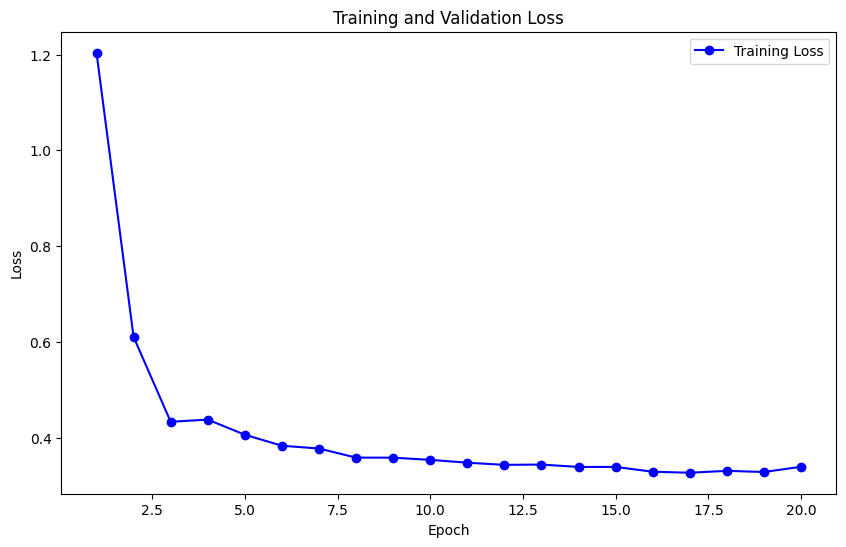

In [198]:
# Epochs range
epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
if val_loss:
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [322]:
def convert_predictions_to_labels(predictions):
    # predictions shape: (batch_size, 848, 848, 6)
    # We use argmax to find the class index with the highest probability for each pixel.
    class_indices = tf.argmax(predictions, axis=-1)
    # The result `class_indices` will have the shape: (batch_size, 848, 848)
    # This is a single-channel image with each pixel value representing the class index.
    return class_indices

# Example usage:
# Assuming `model` is your trained U-Net model and `test_image` is your input image
test_image = val_crop
predictions = model.predict(test_image)  # Get model predictions
predicted_labels = convert_predictions_to_labels(predictions)  # Convert to single-channel labels

# If you need to convert this tensor to a numpy array for further processing or visualization:
predicted_labels_numpy = predicted_labels.numpy()

1/1 [==============================] - 3s 3s/step


In [323]:
predicted_labels.shape

TensorShape([4, 848, 848])

## Plot

In [324]:
images_crop_extra = np.moveaxis(val_crop, -1, 1)
# mask_crop_extra = np.moveaxis(valmask_crop, -1, 1)

images_crop_extra[1].shape

(6, 848, 848)

In [325]:
xx = np.moveaxis(images_crop, -1, 1)
yy = np.moveaxis(mask_crop, -1, 1)

In [326]:
from tifffile import imsave
from PIL import Image
import xarray as xr


(6, 848, 848)

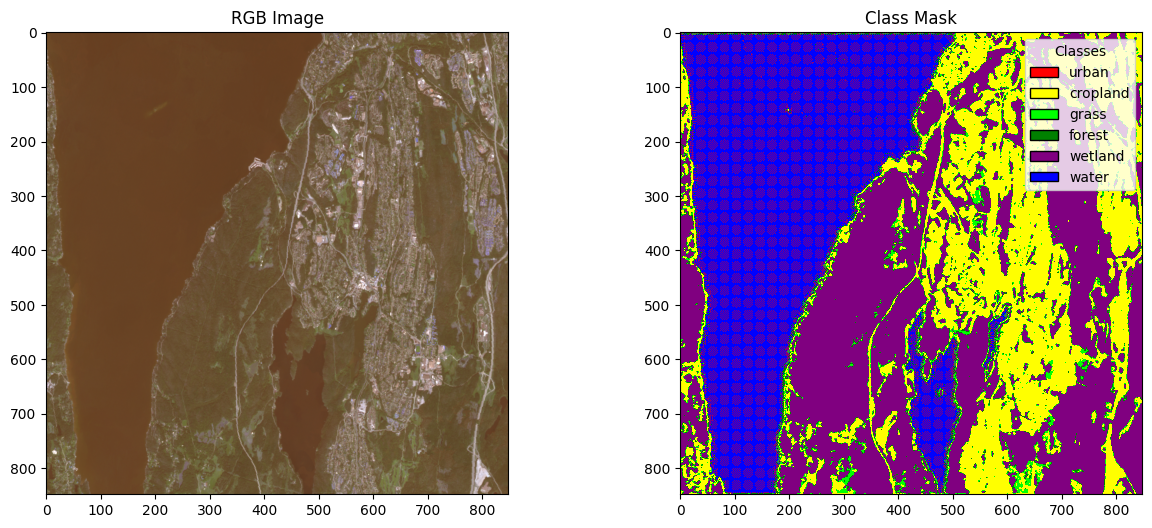

In [336]:
idx = 1



xarray_dataarray = xr.DataArray(images_crop_extra[idx])
xarray_dataarray_mask = xr.DataArray(predicted_labels_numpy[idx])

img = xarray_dataarray
# mask = mask_crop_extra[idx]

_, axs = plt.subplots(1, 2, figsize=(15, 6))

# Define the class labels and corresponding colors
class_labels = ['urban', 'cropland', 'grass', 'forest', 'wetland', 'water']
class_colors = ['red', 'yellow', 'lime', 'green', 'purple', 'blue']

# plot the tile
rgb = img.data[[2, 1, 0]].transpose((1, 2, 0))/2000
axs[0].imshow(rgb.clip(min=0, max=1))
axs[0].set_title("RGB Image")

# # plot the mask
axs[1].imshow(xarray_dataarray_mask.data.squeeze(), cmap=ListedColormap(class_colors))
axs[1].set_title("Class Mask")
legend_elements = [Patch(facecolor=color, edgecolor='black', label=label)
                   for color, label in zip(class_colors, class_labels)]

# Add the legend to the second subplot
axs[1].legend(handles=legend_elements, loc='upper right', title="Classes")

img.shape

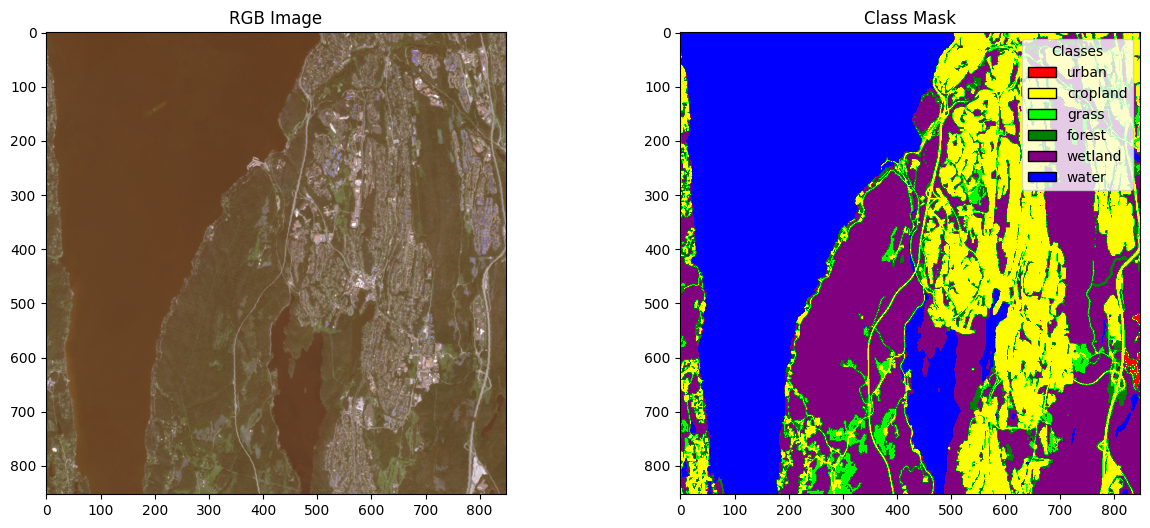

In [337]:
idx = 1
img = rxr.open_rasterio(train_imgs[idx])
mask = rxr.open_rasterio(train_masks[idx])

_, axs = plt.subplots(1, 2, figsize=(15, 6))

# Define the class labels and corresponding colors
class_labels = ['urban', 'cropland', 'grass', 'forest', 'wetland', 'water']
class_colors = ['red', 'yellow', 'lime', 'green', 'purple', 'blue']

# plot the tile
rgb = img.data[[2, 1, 0]].transpose((1, 2, 0))/2000
axs[0].imshow(rgb.clip(min=0, max=1))
axs[0].set_title("RGB Image")

# plot the mask
axs[1].imshow(mask.data.squeeze(), cmap=ListedColormap(class_colors))
axs[1].set_title("Class Mask")
legend_elements = [Patch(facecolor=color, edgecolor='black', label=label)
                   for color, label in zip(class_colors, class_labels)]

# Add the legend to the second subplot
axs[1].legend(handles=legend_elements, loc='upper right', title="Classes")